# Goal

Test between CZB liver and kideny whether the same genes are found to be peripheral/radial/etc consistently

The same genes are present, but the cell-types are different

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob

In [2]:
czb_gene_ont_paths = glob.glob('../../nf_pipeline/outputs/CZB_seqfish_20220728_direct/gene_ont/CZB*.csv')
df = pd.concat(pd.read_csv(p) for p in czb_gene_ont_paths)
df['significant'] = df['bh_p'].le(0.05)

df.head()

,experiment,sample,metric,gene,annotation,num_cells,med_gene_spots,med_spots,med_score,z,p,bh_p,significant
0,CZB_liver,czb_liver,radial,ACE2,periportal hepatocyte,44,2.0,325.0,-0.100,-0.206076,0.836732,0.929717,False
1,CZB_liver,czb_liver,radial,ACTN4,Kupffer cell,73,2.0,221.0,0.026,0.516423,0.605559,0.796957,False
2,CZB_liver,czb_liver,radial,ACTN4,NK cell,31,3.0,245.0,-0.338,-1.198970,0.230540,0.487108,False
3,CZB_liver,czb_liver,radial,ACTN4,hepatic stellate cell,105,4.0,203.0,-0.070,-0.292807,0.769670,0.898713,False
4,CZB_liver,czb_liver,radial,ACTN4,other endothelial cell,53,2.0,195.0,0.198,1.080008,0.280138,0.544126,False


In [3]:
#There are only 2 genes unique to kidney, the rest are shared
liver_genes = set(df[df['experiment'].eq('CZB_liver')]['gene'].unique())
kidney_genes = set(df[df['experiment'].eq('CZB_kidney')]['gene'].unique())
shared_genes = liver_genes.intersection(kidney_genes)

print('Genes unique to liver',liver_genes.difference(kidney_genes))
print('Genes unique to kidney',kidney_genes.difference(liver_genes))

Genes unique to liver set()
Genes unique to kidney {'2210010C04RIK', 'MIR205HG'}


In [4]:
#Count how many cell-types each gene/metric is significant within
sig_celltype_counts = (
    df.groupby(
        ['experiment','metric','gene']
    ).agg(
        sig_celltypes = ('significant','sum'),
        tot_celltypes = ('significant','count'),
        frac_signif_celltypes = ('significant',lambda s: s.sum()/s.count()),
    ).reset_index()
)

sig_celltype_counts

,experiment,metric,gene,sig_celltypes,tot_celltypes,frac_signif_celltypes
0,CZB_kidney,central,1700011H14RIK,7,10,0.700000
1,CZB_kidney,central,2210010C04RIK,0,3,0.000000
2,CZB_kidney,central,ABCC8,3,6,0.500000
3,CZB_kidney,central,ACE2,5,9,0.555556
4,CZB_kidney,central,ACKR1,9,9,1.000000
...,...,...,...,...,...,...
2087,CZB_liver,radial,TNFRSF13B,0,2,0.000000
2088,CZB_liver,radial,UOX,0,10,0.000000
2089,CZB_liver,radial,VSIG4,0,2,0.000000
2090,CZB_liver,radial,VTN,5,10,0.500000


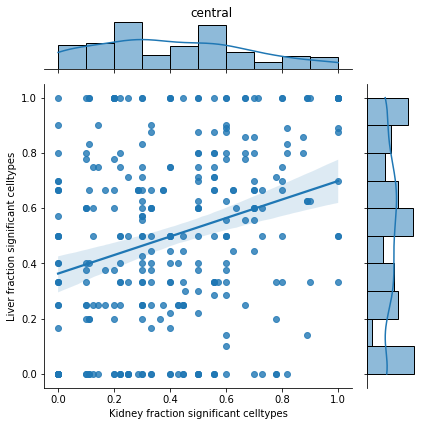

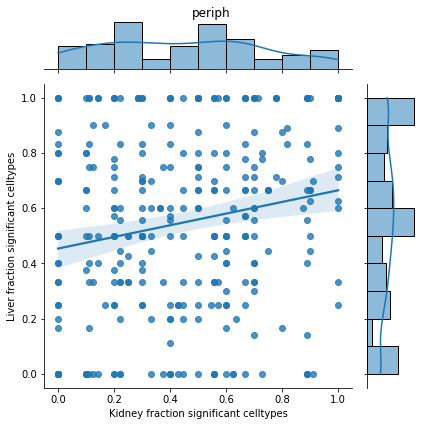

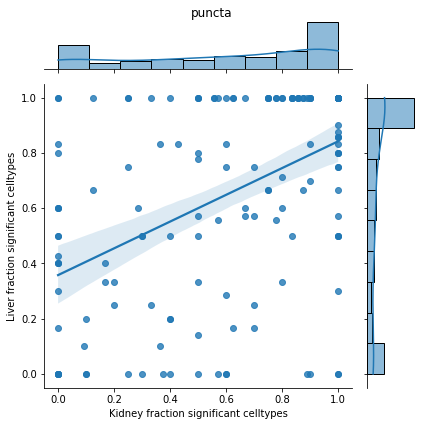

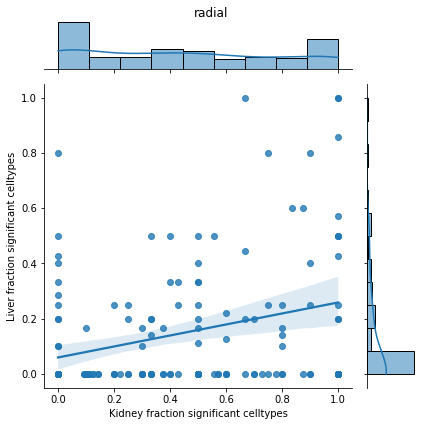

,metric,pearson_r,pearson_p,spearman_r,spearman_p
0,central,0.283064,4.998161e-07,0.262464,3.374036e-06
1,periph,0.188712,9.263617e-04,0.178731,1.725239e-03
2,puncta,0.474024,4.659923e-10,0.459365,1.830290e-09
3,radial,0.304892,1.145969e-04,0.256565,1.270923e-03


In [5]:
p_val_data = {
    'metric':[],
    'pearson_r':[],
    'pearson_p':[],
    'spearman_r':[],
    'spearman_p':[],
}

for metric, g in sig_celltype_counts.groupby('metric'):
    plot_df = g.pivot(
        index='gene',
        columns='experiment',
        values='frac_signif_celltypes',
    ).dropna()
    
    pr,pp = stats.pearsonr(plot_df['CZB_kidney'], plot_df['CZB_liver'])
    sr,sp = stats.spearmanr(plot_df['CZB_kidney'], plot_df['CZB_liver'])
    
    p_val_data['metric'].append(metric)
    p_val_data['pearson_r'].append(pr)
    p_val_data['pearson_p'].append(pp)
    p_val_data['spearman_r'].append(sr)
    p_val_data['spearman_p'].append(sp)
    
    f = sns.jointplot(
        x = 'CZB_kidney',
        y = 'CZB_liver',
        kind = 'reg',
        data = plot_df,
    )
    plt.suptitle(f'{metric}')
    f.fig.tight_layout()
    f.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    
    f.ax_joint.set_xlabel('Kidney fraction significant celltypes')
    f.ax_joint.set_ylabel('Liver fraction significant celltypes')
    plt.show()
    plt.close()
    
    
p_val_df = pd.DataFrame(p_val_data)
p_val_df

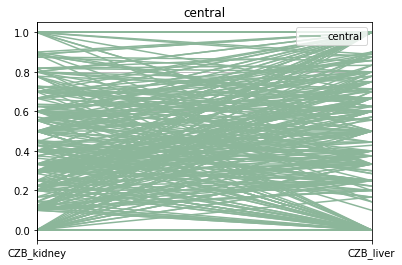

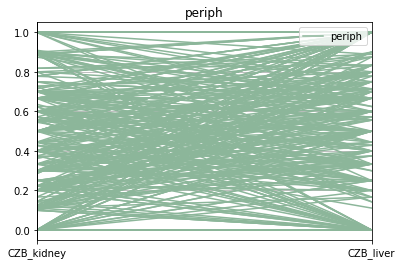

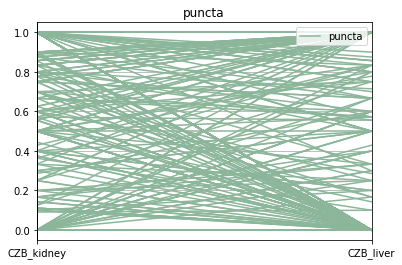

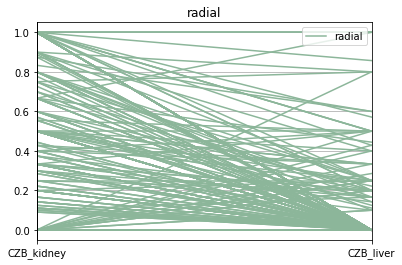

In [6]:
#Making parallel plots
#This is worse visualization than just simple scatterplots...
import pandas.plotting

for metric, g in sig_celltype_counts.groupby('metric'):
    parallel_plot_df = g.pivot(
        index = 'gene',
        columns = 'experiment',
        values = 'frac_signif_celltypes',
    ).fillna(0)
    
    parallel_plot_df['metric'] = metric

    pandas.plotting.parallel_coordinates(parallel_plot_df, 'metric')
    plt.title(f'{metric}')
    plt.show()
    plt.close()

In [7]:
df[['experiment','annotation']].drop_duplicates().reset_index(drop=True)

,experiment,annotation
0,CZB_liver,periportal hepatocyte
1,CZB_liver,Kupffer cell
2,CZB_liver,NK cell
3,CZB_liver,hepatic stellate cell
4,CZB_liver,other endothelial cell
5,CZB_liver,other hepatocyte
6,CZB_liver,pericentral endothelial cell
7,CZB_liver,pericentral hepatocyte
8,CZB_liver,periportal endothelial cell
9,CZB_liver,unannotated


# Limiting above comparison to endothelial cell-types

In [9]:
#Count how many cell-types each gene/metric is significant within
endo_sig_celltype_counts = (
    df[df['annotation'].str.contains('endothelial')].groupby( #This is the line that's difference
        ['experiment','metric','gene']
    ).agg(
        sig_celltypes = ('significant','sum'),
        tot_celltypes = ('significant','count'),
        frac_signif_celltypes = ('significant',lambda s: s.sum()/s.count()),
    ).reset_index()
)

endo_sig_celltype_counts

,experiment,metric,gene,sig_celltypes,tot_celltypes,frac_signif_celltypes
0,CZB_kidney,central,1700011H14RIK,0,1,0.000000
1,CZB_kidney,central,ABCC8,0,1,0.000000
2,CZB_kidney,central,ACE2,0,1,0.000000
3,CZB_kidney,central,ACKR1,1,1,1.000000
4,CZB_kidney,central,ACTA2,0,1,0.000000
...,...,...,...,...,...,...
1589,CZB_liver,radial,TINAGL1,0,1,0.000000
1590,CZB_liver,radial,TM4SF4,0,1,0.000000
1591,CZB_liver,radial,UOX,0,3,0.000000
1592,CZB_liver,radial,VTN,1,3,0.333333


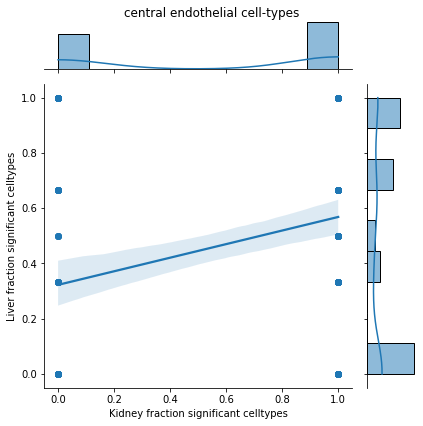

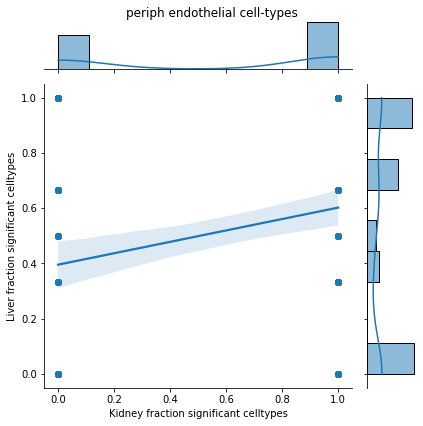

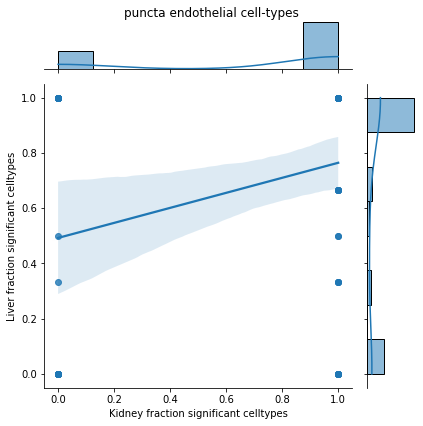

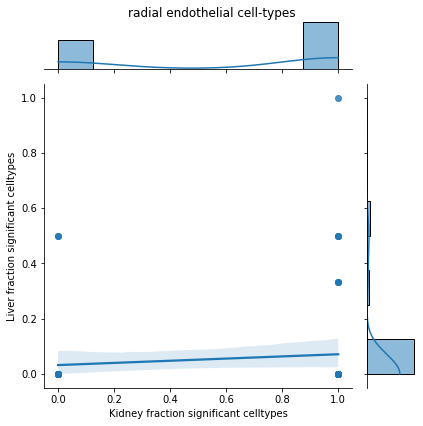

,metric,pearson_r,pearson_p,spearman_r,spearman_p
0,central,0.300559,0.000007,0.299740,0.000008
1,periph,0.249455,0.000220,0.240401,0.000376
2,puncta,0.290992,0.008827,0.255252,0.022307
3,radial,0.111814,0.323420,0.116508,0.303393


In [11]:
p_val_data = {
    'metric':[],
    'pearson_r':[],
    'pearson_p':[],
    'spearman_r':[],
    'spearman_p':[],
}

for metric, g in endo_sig_celltype_counts.groupby('metric'):
    plot_df = g.pivot(
        index='gene',
        columns='experiment',
        values='frac_signif_celltypes',
    ).dropna()
    
    pr,pp = stats.pearsonr(plot_df['CZB_kidney'], plot_df['CZB_liver'])
    sr,sp = stats.spearmanr(plot_df['CZB_kidney'], plot_df['CZB_liver'])
    
    p_val_data['metric'].append(metric)
    p_val_data['pearson_r'].append(pr)
    p_val_data['pearson_p'].append(pp)
    p_val_data['spearman_r'].append(sr)
    p_val_data['spearman_p'].append(sp)
    
    f = sns.jointplot(
        x = 'CZB_kidney',
        y = 'CZB_liver',
        kind = 'reg',
        data = plot_df,
    )
    plt.suptitle(f'{metric} endothelial cell-types')
    f.fig.tight_layout()
    f.fig.subplots_adjust(top=0.95) # Reduce plot to make room 
    
    f.ax_joint.set_xlabel('Kidney fraction significant celltypes')
    f.ax_joint.set_ylabel('Liver fraction significant celltypes')
    plt.show()
    plt.close()
    
    
p_val_df = pd.DataFrame(p_val_data)
p_val_df